# Read data #

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Sat Jan  7 18:35:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!unzip "/content/drive/MyDrive/frames_zip/data.zip" -d "/content"

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
 extracting: /content/20000.png      
 extracting: /content/20001.png      
 extracting: /content/20002.png      
 extracting: /content/20003.png      
 extracting: /content/20004.png      
 extracting: /content/20005.png      
 extracting: /content/20006.png      
 extracting: /content/20007.png      
 extracting: /content/20008.png      
 extracting: /content/20009.png      
 extracting: /content/20010.png      
 extracting: /content/20011.png      
 extracting: /content/20012.png      
 extracting: /content/20013.png      
 extracting: /content/20014.png      
 extracting: /content/20015.png      
 extracting: /content/20016.png      
 extracting: /content/20017.png      
 extracting: /content/20018.png      
 extracting: /content/20019.png      
 extracting: /content/20020.png      
 extracting: /content/20021.png      
 extracting: /content/20022.png      
 extracting: /content/20023.png      
 extracting: /content/2

In [ ]:
DATASET_PATH = "/content/"

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

import numpy as np
import pandas as pd

from PIL import Image

In [ ]:
parameters = pd.read_csv("/content/drive/MyDrive/frames_zip/parameters.csv", index_col=False)

In [ ]:
parameters.head()

width  height  epsilon  ring_center_width  ring_center_height  \
0    640     480      0.0                324                 238   
1    640     480      0.0                324                 239   
2    640     480      0.0                319                 235   
3    640     480      0.0                326                 238   
4    640     480      0.0                314                 241   

   min_brightness  max_brightness  used_noise   filename  
0              80             210         128  00000.png  
1              80             210         381  00001.png  
2              80             210         252  00002.png  
3              80             210         174  00003.png  
4              80             210         291  00004.png

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, path: str, parameters: pd.DataFrame, transform=None) -> None:
        self.image_paths = np.array([path + filename for filename in parameters['filename'].to_numpy()])
        self.labels = parameters['epsilon'].to_numpy()
        self.transform = transform
    
    def __getitem__(self, inx):
        image_path = self.image_paths[inx]
        label_float_epsilon = self.labels[inx]
        target = np.zeros(shape=(1000,))
        target[int(label_float_epsilon*1000)] = 1
        image = Image.open(image_path)
        image = np.array(image)
        # repeat grayscale value three times for all RGB channels
        image = np.repeat(image[..., np.newaxis], 3, -1)
        if self.transform:
            image = self.transform(image)
        return image, torch.from_numpy(target)
        
    def __len__(self):
        return len(self.image_paths)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Testing splitting with sklearn to properly stratify data
train_df, valid_df = train_test_split(parameters, test_size=3750, random_state=12, shuffle=True, stratify=parameters['epsilon'])
train_df, test_df = train_test_split(train_df, test_size=3750, random_state=12, shuffle=True, stratify=train_df['epsilon'])

In [ ]:
print("Unique epsilons in train set: ", len(train_df.groupby(['epsilon'])['epsilon'].count()), ". Number of images: ", len(train_df))
print("Unique epsilons in validation set: ", len(valid_df.groupby(['epsilon'])['epsilon'].count()), ". Number of images: ", len(valid_df))
print("Unique epsilons in test set: ", len(test_df.groupby(['epsilon'])['epsilon'].count()), ". Number of images: ", len(test_df))

Unique epsilons in train set:  1000 . Number of images:  17500
Unique epsilons in validation set:  1000 . Number of images:  3750
Unique epsilons in test set:  1000 . Number of images:  3750


In [ ]:
#Transfor image array into pytorch tensor and normalize it
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:
# Load dataframes into pytorch datasets
training_dataset = ImageDataset(path=DATASET_PATH, parameters=train_df, transform=transform)
validation_dataset = ImageDataset(path=DATASET_PATH, parameters=valid_df, transform=transform)

In [ ]:
test_dataset = ImageDataset(path=DATASET_PATH, parameters=test_df, transform=transform)

In [ ]:
# Load datasets into pytorch dataloaders
training_loader = DataLoader(training_dataset, batch_size=16, shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=True, num_workers=0)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=0)

In [ ]:
def cyclic_MAE(outputs, targets):
    x1 = torch.minimum(torch.abs(outputs-targets), torch.minimum(torch.abs(outputs-targets+1), torch.abs(outputs-targets-1)))
    return torch.mean(x1)

In [ ]:
x1 = np.array([0.002, 0.004, 0.006, 0.6])
x2 = np.array([0.004, 0.998, 0.008, 0.4])
cyclic_MAE(torch.from_numpy(x1).float(), torch.from_numpy(x2).float())

tensor(0.0525)

In [ ]:
import torch.nn as nn
from torchvision import models
import torch.optim as optim
from tqdm import tqdm

In [ ]:
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
classifier = nn.Sequential(
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.ReLU(),
    nn.Linear(512, 1000)
)

In [ ]:
model.fc = classifier

In [ ]:
EPOCHS = 20
LR = 1e-04

In [ ]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

In [ ]:
optimizer = torch.optim.AdamW(params =  model.parameters(), lr=5e-5, eps=1e-8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, factor=0.9, min_lr=1e-5)


NameError: ignored

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)


In [ ]:
min_valid_loss = np.inf
history = {'train_losses': [], 'valid_losses': []}

model.cuda()

for epoch in tqdm(range(EPOCHS)):
    model.train()
    train_batch_losses = []
    for data, labels in training_loader:
        model.zero_grad()
        optimizer.zero_grad()
        images = data.cuda()
        targets = labels.cuda()
        outputs = model(images)
        
        loss = loss_fn(outputs, targets)

        #optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_batch_losses.append(loss.item())
    train_loss = np.sum(train_batch_losses) / len(train_batch_losses)
    history['train_losses'].append(train_loss)

    model.eval()
    fin_targets=[]
    fin_outputs=[]
    valid_batch_losses=[]
    with torch.no_grad():
        for data, labels in validation_loader:
            images = data.cuda()
            targets = labels.cuda()
            outputs = model(images)

            loss = loss_fn(outputs, targets)
            valid_batch_losses.append(loss.item())
        valid_loss = np.sum(valid_batch_losses) / len(valid_batch_losses)
        history['valid_losses'].append(valid_loss)
    
    if min_valid_loss > valid_loss:
        torch.save(model.state_dict(), 'best_model.pth')
        min_valid_loss = valid_loss
    
    print(f'Epoch {epoch} \t\t Training Loss: {train_loss} \t\t Validation Loss: {valid_loss}')
    scheduler.step(valid_loss)


    torch.save(model.state_dict(), 'MODEL.pth')


  5%|▌         | 1/20 [01:57<37:06, 117.19s/it]

Epoch 0 		 Training Loss: 0.03770738029517216 		 Validation Loss: 0.007940590265204262


 10%|█         | 2/20 [03:49<34:13, 114.06s/it]

Epoch 1 		 Training Loss: 0.008344719951768059 		 Validation Loss: 0.007517873518268062


 15%|█▌        | 3/20 [05:39<31:53, 112.56s/it]

Epoch 2 		 Training Loss: 0.007421035530538169 		 Validation Loss: 0.006291968688032151


 20%|██        | 4/20 [07:30<29:48, 111.79s/it]

Epoch 3 		 Training Loss: 0.006432682624564221 		 Validation Loss: 0.005636568517713147


 25%|██▌       | 5/20 [09:22<27:56, 111.78s/it]

Epoch 4 		 Training Loss: 0.00590649594505586 		 Validation Loss: 0.005204227669165228


 30%|███       | 6/20 [11:13<26:00, 111.47s/it]

Epoch 5 		 Training Loss: 0.005539004587918705 		 Validation Loss: 0.004928988538786696


 35%|███▌      | 7/20 [13:04<24:07, 111.36s/it]

Epoch 6 		 Training Loss: 0.005250223731652814 		 Validation Loss: 0.004697564751043866


 40%|████      | 8/20 [14:54<22:13, 111.12s/it]

Epoch 7 		 Training Loss: 0.0049943868145995735 		 Validation Loss: 0.004478463961269678


 45%|████▌     | 9/20 [16:45<20:19, 110.86s/it]

Epoch 8 		 Training Loss: 0.004780069473665622 		 Validation Loss: 0.004297565351079822


 50%|█████     | 10/20 [18:35<18:25, 110.59s/it]

Epoch 9 		 Training Loss: 0.004596894008927986 		 Validation Loss: 0.004154842714948718


 55%|█████▌    | 11/20 [20:25<16:34, 110.54s/it]

Epoch 10 		 Training Loss: 0.004432133936780536 		 Validation Loss: 0.004028949911833346


 60%|██████    | 12/20 [22:15<14:41, 110.23s/it]

Epoch 11 		 Training Loss: 0.004280449727574611 		 Validation Loss: 0.0038775509999387477


 65%|██████▌   | 13/20 [24:04<12:50, 110.11s/it]

Epoch 12 		 Training Loss: 0.0041540187084688944 		 Validation Loss: 0.0037943360209687447


 70%|███████   | 14/20 [25:53<10:58, 109.79s/it]

Epoch 13 		 Training Loss: 0.004040801619515721 		 Validation Loss: 0.003716513949036261


 75%|███████▌  | 15/20 [27:43<09:08, 109.68s/it]

Epoch 14 		 Training Loss: 0.003941664068472002 		 Validation Loss: 0.0037158642250565374


 80%|████████  | 16/20 [29:32<07:18, 109.56s/it]

Epoch 15 		 Training Loss: 0.003845911981137171 		 Validation Loss: 0.0035782188386559916


 85%|████████▌ | 17/20 [31:21<05:28, 109.50s/it]

Epoch 16 		 Training Loss: 0.0037724246727416076 		 Validation Loss: 0.003575940185885929


 90%|█████████ | 18/20 [33:11<03:39, 109.59s/it]

Epoch 17 		 Training Loss: 0.0036919913469212447 		 Validation Loss: 0.003514100221186556


 95%|█████████▌| 19/20 [35:01<01:49, 109.57s/it]

Epoch 18 		 Training Loss: 0.0036383551671327805 		 Validation Loss: 0.003443359952317576


100%|██████████| 20/20 [36:50<00:00, 110.53s/it]

Epoch 19 		 Training Loss: 0.0035622147598330708 		 Validation Loss: 0.003520036317367936


In [ ]:
import matplotlib.pyplot as plt

In [ ]:


def plot_loss(train_loss, valid_loss):
  y = [*range(len(train_loss))]
  plt.plot(y, train_loss, "orange")
  plt.plot(y, valid_loss, "blue")
  plt.show()

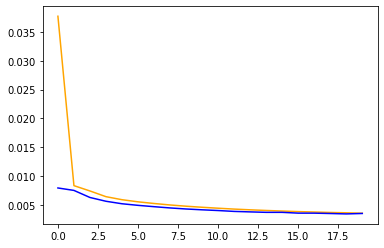

In [ ]:
plot_loss(history['train_losses'], history['valid_losses'])

In [ ]:
def test(test_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for data, labels in tqdm(test_loader):
            images = data.cuda()
            targets = labels.cuda()
            outputs = model(images)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets


In [ ]:
outputs, targets = test(test_loader)

100%|██████████| 235/235 [00:24<00:00,  9.50it/s]


In [ ]:
outputs_numpy = np.array(outputs)
out = np.zeros_like(outputs_numpy)
out[np.arange(len(outputs_numpy)), outputs_numpy.argmax(1)] = 1

In [ ]:
out = out.tolist()

In [ ]:
def cyclic_MAE(output, target):
    return min(abs(output-target), min(abs(output-target+1), abs(output-target-1)))
    

In [ ]:
def save_results(outputs, targets, filename: str):
  epsilons = []
  predicted = []
  differences = []
  for out, tar in zip(outputs, targets):

    epsilons.append(tar.index(1)/1000)
    predicted.append(out.index(1)/1000)
    differences.append(cyclic_MAE(out.index(1)/1000, tar.index(1)/1000))
  results_df = pd.DataFrame(list(zip(epsilons, predicted, differences)),
               columns =['epsilon', 'predicted', 'loss'])
  results_df.to_csv(filename, index=False)
  return results_df
  


In [ ]:
results = save_results(out, targets, "BCE-1k-multiclass_20epochs_resnet50.csv")  

In [ ]:
from google.colab import files

In [ ]:
files.download("/content/MODEL.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
results['loss'].mean()

0.0019503999999999995

In [ ]:
def plot_loss(results: pd.DataFrame) -> None:
  sorted = results.sort_values(by=['epsilon'])
  plt.scatter(sorted['epsilon'], sorted['loss'])
  plt.show()


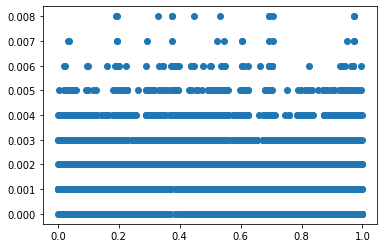

In [ ]:
plot_loss(results)

In [ ]:
import seaborn as sns

In [ ]:
sorted = results.sort_values(by=['epsilon'])
grouped_mean = sorted.groupby(['epsilon'])['loss'].mean()

In [ ]:
grouped_mean

epsilon
0.000    0.006000
0.001    0.006333
0.002    0.007000
0.003    0.007000
0.004    0.004000
           ...   
0.995    0.008500
0.996    0.006000
0.997    0.006000
0.998    0.006333
0.999    0.006750
Name: loss, Length: 1000, dtype: float64

In [ ]:
model = models.resnet50(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
classifier = nn.Sequential(
    nn.Linear(2048, 2048),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.ReLU(),
    nn.Linear(2048, 1000)
)

In [ ]:
model.fc = classifier

In [ ]:
EPOCHS = 20

In [ ]:
optimizer = torch.optim.AdamW(params =  model.parameters(), lr=5e-5, eps=1e-8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, factor=0.9, min_lr=1e-5)

In [ ]:
min_valid_loss = np.inf
history = {'train_losses': [], 'valid_losses': []}

model.cuda()

for epoch in tqdm(range(EPOCHS)):
    model.train()
    train_batch_losses = []
    for data, labels in training_loader:
        model.zero_grad()
        optimizer.zero_grad()
        images = data.cuda()
        targets = labels.cuda()
        outputs = model(images)
        
        loss = loss_fn(outputs, targets)

        #optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_batch_losses.append(loss.item())
    train_loss = np.sum(train_batch_losses) / len(train_batch_losses)
    history['train_losses'].append(train_loss)

    model.eval()
    fin_targets=[]
    fin_outputs=[]
    valid_batch_losses=[]
    with torch.no_grad():
        for data, labels in validation_loader:
            images = data.cuda()
            targets = labels.cuda()
            outputs = model(images)

            loss = loss_fn(outputs, targets)
            valid_batch_losses.append(loss.item())
        valid_loss = np.sum(valid_batch_losses) / len(valid_batch_losses)
        history['valid_losses'].append(valid_loss)
    
    if min_valid_loss > valid_loss:
        torch.save(model.state_dict(), 'best_model.pth')
        min_valid_loss = valid_loss
    
    print(f'Epoch {epoch} \t\t Training Loss: {train_loss} \t\t Validation Loss: {valid_loss}')
    scheduler.step(valid_loss)


    torch.save(model.state_dict(), 'MODEL.pth')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0 		 Training Loss: 0.018807499769505773 		 Validation Loss: 0.007965888450595631


  5%|▌         | 1/20 [04:11<1:19:29, 251.04s/it]

Epoch 1 		 Training Loss: 0.00769098412992087 		 Validation Loss: 0.00644392707754917


 10%|█         | 2/20 [08:20<1:15:04, 250.26s/it]

Epoch 2 		 Training Loss: 0.006327578369524519 		 Validation Loss: 0.005569721706428812


 15%|█▌        | 3/20 [12:28<1:10:33, 249.04s/it]

Epoch 3 		 Training Loss: 0.005673861572856506 		 Validation Loss: 0.005134967760774684


 20%|██        | 4/20 [16:37<1:06:22, 248.91s/it]

Epoch 4 		 Training Loss: 0.005252591387804344 		 Validation Loss: 0.004821873677473847


 25%|██▌       | 5/20 [20:44<1:02:07, 248.49s/it]

Epoch 5 		 Training Loss: 0.0049321018076437856 		 Validation Loss: 0.004491991266770342


 30%|███       | 6/20 [24:52<57:53, 248.12s/it]  

Epoch 6 		 Training Loss: 0.004678315808245273 		 Validation Loss: 0.004311446300033099


 35%|███▌      | 7/20 [28:59<53:41, 247.80s/it]

Epoch 7 		 Training Loss: 0.00447690604189735 		 Validation Loss: 0.004075016224919869


 40%|████      | 8/20 [33:05<49:28, 247.38s/it]

Epoch 8 		 Training Loss: 0.004289166050893425 		 Validation Loss: 0.003966915931008416


 45%|████▌     | 9/20 [37:13<45:20, 247.32s/it]

Epoch 9 		 Training Loss: 0.004149896907671054 		 Validation Loss: 0.0038572938123666114


 50%|█████     | 10/20 [41:20<41:12, 247.28s/it]

Epoch 10 		 Training Loss: 0.004030608126911722 		 Validation Loss: 0.003847602659941841


 55%|█████▌    | 11/20 [45:27<37:04, 247.18s/it]

Epoch 11 		 Training Loss: 0.0039227562833497025 		 Validation Loss: 0.0036527332114643643


 60%|██████    | 12/20 [49:34<32:59, 247.38s/it]

Epoch 12 		 Training Loss: 0.003810909600069546 		 Validation Loss: 0.003572407349846233


 65%|██████▌   | 13/20 [53:43<28:53, 247.69s/it]

Epoch 13 		 Training Loss: 0.003738710513716944 		 Validation Loss: 0.0035674391961755835


 70%|███████   | 14/20 [57:52<24:47, 247.99s/it]

Epoch 14 		 Training Loss: 0.003673869539214115 		 Validation Loss: 0.0034911534372257256


 75%|███████▌  | 15/20 [1:02:00<20:40, 248.02s/it]

Epoch 15 		 Training Loss: 0.0036083525707280304 		 Validation Loss: 0.0034963779921558624


 80%|████████  | 16/20 [1:06:08<16:32, 248.21s/it]

Epoch 16 		 Training Loss: 0.0035330424988866366 		 Validation Loss: 0.0033259218045791545


 85%|████████▌ | 17/20 [1:10:16<12:23, 247.96s/it]

Epoch 17 		 Training Loss: 0.003515764232030362 		 Validation Loss: 0.0032557625002942003


 90%|█████████ | 18/20 [1:14:22<08:14, 247.48s/it]

Epoch 18 		 Training Loss: 0.0034363561718420634 		 Validation Loss: 0.003312647784003572


 95%|█████████▌| 19/20 [1:18:28<04:07, 247.10s/it]

Epoch 19 		 Training Loss: 0.003401828747209171 		 Validation Loss: 0.003284719611394323


100%|██████████| 20/20 [1:22:35<00:00, 247.76s/it]


In [ ]:
model = models.resnet50(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
from google.colab import files
files.download('best_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>